In [309]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [310]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)
con = 100

In [311]:
import os 

In [312]:
# Importing the database 

df = pd.read_csv("/Users/vineeth/Documents/NYIT_MS/Information Retrieval/Questions.csv", encoding="ISO-8859-1")

In [313]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [314]:
tags = pd.read_csv("/Users/vineeth/Documents/NYIT_MS/Information Retrieval/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [315]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [317]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [318]:
tags['Tag'] = tags['Tag'].astype(str)

In [319]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [320]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [321]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [322]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [323]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [324]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [325]:
df = df.merge(grouped_tags_final, on='Id')

In [326]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [327]:
new_df = df[df['Score']>5]

In [328]:
test_df = df[6000:6100]

In [329]:
test_df.head()

,Id,Score,Title,Body,Tags
6000,415240,3,.NET Class Refactoring Dilemma,<p>So I'm refactoring a legacy codebase I've i...,c# .net oop refactoring
6001,415260,20,How do you find out what users really want?,"<p>I've read somewhere (I forget the source, s...",user-experience
6002,415310,2,Flash security: problem loading Flash 8 AS2 mo...,<p>I have an old program written in Actionscri...,flash security loading
6003,415520,7,How do I make Tomcat stop caching my servlet r...,"<p>I'm learning Servlets programming, using Ap...",java tomcat servlets caching
6004,415550,11,prototype and jQuery peaceful co-existence?,<p>I know very little about JavaScript but des...,javascript jquery wordpress prototypejs


In [330]:
new_df = new_df.head(30000)

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

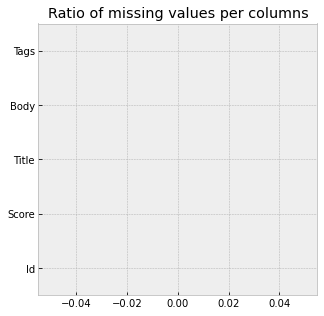

In [331]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [332]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [333]:
test_df.drop_duplicates(inplace = True)

In [334]:
print('Dupplicate entries: {}'.format(test_df.duplicated().sum()))

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [335]:
new_df.drop(columns=['Id', 'Score'], inplace=True)
test_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [336]:
new_df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [337]:
test_df.head()

,Title,Body,Tags
6000,.NET Class Refactoring Dilemma,<p>So I'm refactoring a legacy codebase I've i...,c# .net oop refactoring
6001,How do you find out what users really want?,"<p>I've read somewhere (I forget the source, s...",user-experience
6002,Flash security: problem loading Flash 8 AS2 mo...,<p>I have an old program written in Actionscri...,flash security loading
6003,How do I make Tomcat stop caching my servlet r...,"<p>I'm learning Servlets programming, using Ap...",java tomcat servlets caching
6004,prototype and jQuery peaceful co-existence?,<p>I know very little about JavaScript but des...,javascript jquery wordpress prototypejs


In [338]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [339]:
test_df['Tags'] = test_df['Tags'].apply(lambda x: x.split())

In [340]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [341]:
all_tags_test = [item for sublist in test_df['Tags'].values for item in sublist]

In [342]:
len(all_tags)

89751

In [343]:
len(all_tags_test)

293

In [344]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

8514

In [345]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [346]:
tags_features

['c#',
 'java',
 'c++',
 'javascript',
 'python',
 '.net',
 'php',
 'android',
 'jquery',
 'iphone',
 'c',
 'html',
 'sql',
 'asp.net',
 'ruby-on-rails',
 'objective-c',
 'css',
 'mysql',
 'ruby',
 'sql-server',
 'wpf',
 'asp.net-mvc',
 'string',
 'git',
 'linux',
 'windows',
 'performance',
 'django',
 'algorithm',
 'eclipse',
 'database',
 'visual-studio',
 'regex',
 'multithreading',
 'ios',
 'arrays',
 'xml',
 'unit-testing',
 'cocoa-touch',
 'winforms',
 'perl',
 'ajax',
 'osx',
 'delphi',
 'cocoa',
 'linq',
 'visual-studio-2010',
 'scala',
 'r',
 'svn',
 'bash',
 'debugging',
 'json',
 'security',
 'oop',
 'xcode',
 'tsql',
 'ruby-on-rails-3',
 'vim',
 'haskell',
 'math',
 'spring',
 'language-agnostic',
 'user-interface',
 'generics',
 'oracle',
 'exception',
 'version-control',
 'shell',
 'html5',
 'wcf',
 'image',
 'hibernate',
 'emacs',
 'http',
 'vb.net',
 'file',
 'visual-studio-2008',
 'entity-framework',
 'design-patterns',
 'list',
 'asp.net-mvc-3',
 'reflection',
 'ipad

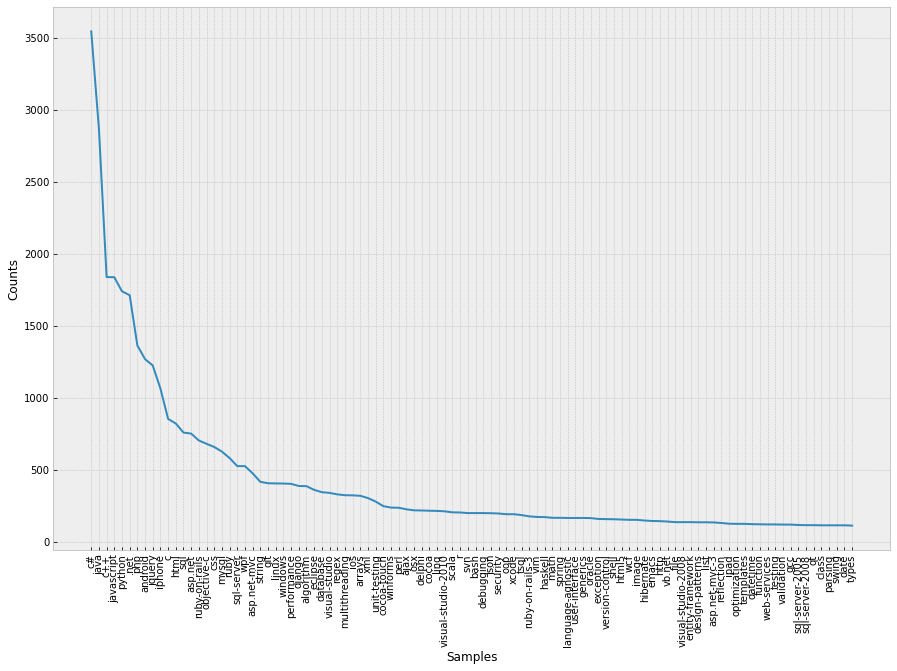

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [347]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [348]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [349]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [350]:
new_df.dropna(subset=['Tags'], inplace=True)

In [351]:
new_df.shape

(26239, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In [352]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [353]:
test_df['Body'] = test_df['Body'].apply(lambda x: BeautifulSoup(x).get_text())

In [354]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [355]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [356]:
test_df['Body'] = test_df['Body'].apply(lambda x: clean_text(x)) 

In [357]:
token=ToktokTokenizer()

In [358]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [359]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [360]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [361]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [362]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [363]:
test_df['Body'] = test_df['Body'].apply(lambda x: clean_punct(x)) 

In [364]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [365]:
test_df['Body'][6003]

'i am learning servlets programming using apache tomcat 6 on a ubuntu 810 machine and i am running with a very annoying issue -- apparently related to caching this is what i am doing i write a servlet put it in a nice directory structure and deploy it using the tomcat web application manager it works as expected then i edit the servlet recompile and try to access it again but tomcat keeps returning the same old version reloading the application or even restarting the server does not work the only thing that works is undeploying the application then deploying it all over again i have to do this every single time i make any small change on my code it sucks i am sure there is a way around this but i could not find the answer anywhere on the web and i did search a lot i would really appreciate any help thanks'

In [366]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [367]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [368]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

In [369]:
test_df['Body'] = test_df['Body'].apply(lambda x: lemitizeWords(x)) 
test_df['Body'] = test_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [370]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [371]:
test_df['Title'] = test_df['Title'].apply(lambda x: str(x))
test_df['Title'] = test_df['Title'].apply(lambda x: clean_text(x)) 
test_df['Title'] = test_df['Title'].apply(lambda x: clean_punct(x)) 
test_df['Title'] = test_df['Title'].apply(lambda x: lemitizeWords(x)) 
test_df['Title'] = test_df['Title'].apply(lambda x: stopWordsRemove(x))

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [372]:
no_topics = 20

In [373]:
text = new_df['Body']

In [374]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [375]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [376]:
lda = LatentDirichletAllocation(max_iter=5, n_components= 20,learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [377]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
android div image width height css style html id text
--------------------------------------------
--------------------------------------------
Topic 1:
url request mvc controller asp.net session page http action view
--------------------------------------------
--------------------------------------------
Topic 2:
class public object method void new return string type call
--------------------------------------------
--------------------------------------------
Topic 3:
color button window bind wpf text view video control label
--------------------------------------------
--------------------------------------------
Topic 4:
visual studio 2010 vs xcode 2008 phone debug mac windows
--------------------------------------------
--------------------------------------------
Topic 5:
c++ equivalent c# frame struct ref stack pointer similar prevent
--------------------------------------------
--------------------------------------------
T

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [378]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [379]:
X3 = test_df['Body']
X4 = test_df['Title']

In [380]:
print(type(X1))
print(type(X3))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [381]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [382]:
new_df.head

<bound method NDFrame.head of                                                     Title  \
1                 good branch merge tutorials tortoisesvn   
2                                        asp.net site map   
3                             function create color wheel   
4              add script functionality .net applications   
5                                     use nest class case   
...                                                   ...   
177773            lossless hierarchical run length encode   
177790                     inheritance resource file resx   
177816                               integrate app google   
177833           django handle multiple memcached servers   
177861  document ready necessary put javascript bottom...   

                                                     Body  \
1       really good tutorials explain branch merge apa...   
2       anyone get experience create sql-based asp.net...   
3       something pseudo-solved many time never quite 

In [383]:
y_bin[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [384]:
list(multilabel_binarizer.classes_)

['.net',
 'ajax',
 'algorithm',
 'android',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'asp.net-mvc-3',
 'bash',
 'c',
 'c#',
 'c++',
 'class',
 'cocoa',
 'cocoa-touch',
 'css',
 'database',
 'date',
 'datetime',
 'debugging',
 'delphi',
 'design-patterns',
 'django',
 'eclipse',
 'emacs',
 'entity-framework',
 'exception',
 'file',
 'function',
 'gcc',
 'generics',
 'git',
 'haskell',
 'hibernate',
 'html',
 'html5',
 'http',
 'image',
 'ios',
 'ipad',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'json',
 'language-agnostic',
 'linq',
 'linux',
 'list',
 'math',
 'multithreading',
 'mysql',
 'objective-c',
 'oop',
 'optimization',
 'oracle',
 'osx',
 'parsing',
 'performance',
 'perl',
 'php',
 'python',
 'qt',
 'r',
 'reflection',
 'regex',
 'ruby',
 'ruby-on-rails',
 'ruby-on-rails-3',
 'scala',
 'security',
 'shell',
 'spring',
 'sql',
 'sql-server',
 'sql-server-2005',
 'sql-server-2008',
 'string',
 'svn',
 'swing',
 'templates',
 'testing',
 'tsql',
 'types',
 'unit-testing',
 'u

In [385]:
len(y_bin)

26239

In [386]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [387]:
vectorizer_X3 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X4 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [388]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [389]:
X1_tfidf

<26239x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 740048 stored elements in Compressed Sparse Row format>

In [390]:
X3_tfidf = vectorizer_X1.fit_transform(X3)
X4_tfidf = vectorizer_X2.fit_transform(X4)

In [391]:
X3_tfidf

<100x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 3350 stored elements in Compressed Sparse Row format>

In [392]:
X4_tfidf

<100x411 sparse matrix of type '<class 'numpy.float64'>'
	with 531 stored elements in Compressed Sparse Row format>

In [393]:
X4_tfidf.reshape(100,-1)

<100x411 sparse matrix of type '<class 'numpy.float64'>'
	with 531 stored elements in Compressed Sparse Row format>

In [394]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [395]:
type(X_tfidf)

scipy.sparse.coo.coo_matrix

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

Now it's finally ready. 

**2.2 One vs Rest**

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification. 

In [397]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("Accuracy: {}".format((accuracy_score(y_pred, y_test)*con)))
    print("---")    

In [398]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Predicted:",multilabel_binarizer.inverse_transform(y_pred[0:10,:]))
    print("\nActual: ",multilabel_binarizer.inverse_transform(y_test[0:10,:]))
    print_score(y_pred, classifier)

Predicted: [(), (), (), (), (), (), (), (), (), ()]

Actual:  [('ajax', 'javascript', 'jquery'), ('ruby-on-rails',), ('asp.net-mvc', 'c#'), ('.net', 'java'), ('ruby', 'ruby-on-rails', 'ruby-on-rails-3'), ('php',), ('html5', 'iphone', 'javascript'), ('sql',), ('javascript',), ('c++',)]
Clf:  DummyClassifier
Jacard score: 0.0
Hamming loss: 1.6028963414634148
Accuracy: 0.0
---
Predicted: [('ajax',), (), ('c#',), ('java',), ('ruby-on-rails',), ('php',), ('javascript',), ('sql',), (), ('c++',)]

Actual:  [('ajax', 'javascript', 'jquery'), ('ruby-on-rails',), ('asp.net-mvc', 'c#'), ('.net', 'java'), ('ruby', 'ruby-on-rails', 'ruby-on-rails-3'), ('php',), ('html5', 'iphone', 'javascript'), ('sql',), ('javascript',), ('c++',)]
Clf:  SGDClassifier
Jacard score: 50.70566565040651
Hamming loss: 0.9420731707317073
Accuracy: 36.77591463414634
---
Predicted: [('ajax',), (), ('.net', 'c#'), ('java',), ('ruby-on-rails',), ('php',), ('javascript',), ('sql',), (), ('c++',)]

Actual:  [('ajax', 'javascri